In [5]:
# palm muscles
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.signal import butter, filtfilt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [7]:
file_path = r"C:\Users\mrpap\OneDrive\Desktop\ecg signals\emg\EMG final.xlsx"
df = pd.read_excel(file_path)

emg_channels = [
    "EMG_1_A_Palm_front",
    "EMG_1_B_Palm_back",
    "EMG_2_Forearm",
    "EMG_3_Bicep"
]

label_column = "class"
    

In [8]:
# bandpass filter (20-500 Hz)

def bandpass_filter(signal, fs=2000, low=20, high=500, order=4):
    nyq = 0.5 * fs
    low_cut = low/nyq
    high_cut = high/nyq
    b, a = butter(order, [low_cut, high_cut], btype="band")
    return filtfilt(b, a, signal)

In [9]:
def iemg(x): #Adds up all absolute EMG values. Meaning: total muscle activity.
    return np.sum(np.abs(x))

def ssi(x): #Squares EMG and sums it.
    return np.sum(x**2)

def mav(x): #Average muscle activation level. Summing the absolute values of the amplitude 
    #and dividing by the number of samples.
    return np.mean(np.abs(x))

def rms(x): # Strength of EMG signal. Average power over a time segment
    return np.sqrt(np.mean(x**2))

def wl(x):  #Measures how much the signal chamges. Waveform length calculated
    #the difference between adjacent samples, takes the absolute value, and sums these values.
    return np.sum(np.abs(np.diff(x)))

def wamp(x, threhold=0.01): #Willsion Amplitude Counts how many times signal jumps above threshold.
    return np.sum(np.abs(np.diff(x)) > threshold)
    
def wampv(x, threshold=0.01):  #variance of those jumps
    diff = np.abs(np.diff(x))
    active = diff[diff > threshold]
    return np.var(active) if len (active) > 0 else 0
    


In [10]:
# ============================================================
# 4. SLIDING WINDOW FEATURE EXTRACTION (28 Total Features)
# ============================================================

fs = 2000  # Sampling frequency (paper)

window_size = int(0.2 * fs)   # 400 ms window
step_size   = int(0.05 * fs)  # 100 ms step overlap #0-399 then 100-499

threshold = 0.01

feature_rows = [] #Empty list to store extracted feature rows.

for start in range(0, len(df) - window_size, step_size): #Example:window 1: samples 0–399,window 2: samples 100–499
                                                         #window 3: samples 200–599

    # Window label (majority vote)
    window_label = df[label_column].iloc[start:start+window_size].mode()[0] #Look at all the class values inside this window,
                                                                            #and choose the most common one (majority vote).

        #because there can be more than one answer, therefore the first element of mode()[0] is selected
        
    row_features = [] #Stores features for this window.

    # Extract features from each channel
    for ch in emg_channels:

        raw_signal = df[ch].values[start:start+window_size]

        # Apply bandpass filtering
        filtered = bandpass_filter(raw_signal, fs)

        # Extract 7 features
        row_features.extend([
            iemg(filtered),
            ssi(filtered),
            mav(filtered),
            rms(filtered),
            wl(filtered),
            wamp(filtered, threshold),
            wampv(filtered, threshold)
        ])
     #row_features = [7 features of ch1,7 features of ch2,7 features of ch3,7 features of ch4]
    # Append label at end
    row_features.append(window_label)

    feature_rows.append(row_features) #(19, 29)=(19 windows, 28 features+1 label)


In [11]:
np.shape(feature_rows)

(19, 29)

In [12]:
# ============================================================
# 5. CREATE FEATURE DATAFRAME (28 Features + Class)
# ============================================================

feature_names = []

for ch in emg_channels:
    feature_names.extend([
        f"{ch}_IEMG",
        f"{ch}_SSI",
        f"{ch}_MAV",
        f"{ch}_RMS",
        f"{ch}_WL",
        f"{ch}_WAMP",
        f"{ch}_WAMPV"
    ])

feature_names.append("Class")

features_df = pd.DataFrame(feature_rows, columns=feature_names) #Converts feature list into a proper table.Rows = windows
                                                                #Columns = features

print("Feature Dataset Shape:", features_df.shape)


Feature Dataset Shape: (19, 29)


In [19]:
# ============================================================
# 6. SPLIT FEATURES + LABELS
# ============================================================

X = features_df.drop("Class", axis=1) #Include all emg features and remove the Class column. Axis=1 is for column
y = features_df["Class"] #include only the class column


# ============================================================
# 7. STANDARDIZATION (Required Before PCA)
# ============================================================
#Features have very different scales
# Machine learning and PCA work using distance and variance. If one feature has large values, it will dominate everything.

# Example:
# Feature A ranges: 0 to 1
# Feature B ranges: 0 to 5000
# Then Feature B will completely overpower Feature A.

# So the model will ignore small-scale features.

# Solution: Standardization makes all features comparable.

# It converts every feature into the same scale:

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) # as only x contains emg


# ============================================================
# 8. PCA REDUCTION → 6 COMPONENTS (Paper Uses 95% Variance)
# ============================================================
#Many of them are correlated.Example:RMS and MAV are similar, IEMG and SSI are related
#Instead of using 28 features, use fewer new features that still contain most information

pca = PCA(n_components=6)

# They are new artificial features made by combining old ones.
# Example:

# PC1 might be:PC1=0.3(RMS)+0.2(MAV)+0.5(IEMG)+…

# So PC1 is like a summary feature.

X_pca = pca.fit_transform(X_scaled)

# Before PCA:X=(19, 28)
# After PCA: =(19, 6)

# So data becomes smaller.

print("\nExplained Variance Ratio:", pca.explained_variance_ratio_)
print("Total Variance Explained:", np.sum(pca.explained_variance_ratio_))




Explained Variance Ratio: [0.50346235 0.23592143 0.13275933 0.08174303 0.02064848 0.01393486]
Total Variance Explained: 0.988469472676197


In [20]:
# ============================================================
# 9. TRAIN-TEST SPLIT
# ============================================================

X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y,
    test_size=0.2, #Training windows ≈ 15,Testing windows ≈ 4
    random_state=42,
    stratify=y #Each gesture class is proportionally present in both train and test sets.
)


# ============================================================
# 10. RANDOM FOREST CLASSIFIER (Paper Model)
# ============================================================

rf_model = RandomForestClassifier(
    n_estimators=200, #Use 200 decision trees
    random_state=42
)

rf_model.fit(X_train, y_train) #Model looks at EMG features and their correct gesture labels.

# True Positive (TP)=Model predicted Gesture 1,AND it was actually Gesture 1
# False Positive (FP)=Model predicted Gesture 1,BUT actually it was another gesture
# False Negative (FN)=Model did NOT predict Gesture 1,BUT actually it was Gesture 1
# True Negative (TN)=Model predicted NOT Gesture 1,AND it was not Gesture 1

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",200
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

In [21]:
# ============================================================
# 11. MODEL EVALUATION
# ============================================================

y_pred = rf_model.predict(X_test)

print("\n========== RANDOM FOREST RESULTS ==========")
print("Accuracy:", accuracy_score(y_test, y_pred))

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# Precision tells when the model says “Gesture 1”, how often is it correct? or few false alarms
# Precision=TP/TP+FP

# Example:

# Model predicted Gesture 1 a total of 10 times:
# 7 were correct (TP=7), 3 were wrong (FP=3)

# So:Precision=7/7+3 = 0.70, So precision = 70%



# Recall tells Out of all actual Gesture 1 cases, how many did the model catch? or how many missed cases?

# Formula:Recall= TP/TP+FN
# Example:

# There were 12 actual Gesture 1 windows:

# Model correctly found 7 (TP=7), Model missed 5 (FN=5)
# So,Recall=7/7+5=0.58 or 58%


# Sometimes precision is high but recall is low, or vice versa.

# So F1-score combines both.
# Formula:F1=2×(Precision*Recall)/(Precision+Recall)
# Example:

# Precision = 0.70
# Recall = 0.58
# F= 2*0.7*0.58/1.28 =0.63 or 63%

# Support is How many true samples of that class exist?
# Example: If test set contains:
# Gesture 1 → 10 windows
# Gesture 2 → 5 windows

# Then:
# Support for Gesture 1 = 10
# Support for Gesture 2 = 5

# Accuracy is Out of all predictions, how many were correct?

# Formula:
# Accuracy=TP+TN/TP+FP+FN+TN = Correct Predictions/Total Predictions



========== RANDOM FOREST RESULTS ==========
Accuracy: 0.5

Classification Report:

              precision    recall  f1-score   support

           1       0.33      1.00      0.50         1
           2       1.00      0.50      0.67         2
           3       0.00      0.00      0.00         1

    accuracy                           0.50         4
   macro avg       0.44      0.50      0.39         4
weighted avg       0.58      0.50      0.46         4



D:\anaconda\envs\notebook-7.0.8\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
D:\anaconda\envs\notebook-7.0.8\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
D:\anaconda\envs\notebook-7.0.8\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


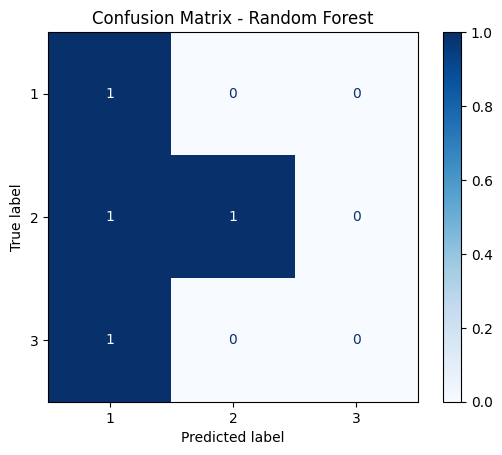

In [22]:
# ============================================================
# 12. CONFUSION MATRIX PLOT
# ============================================================
class_labels = [1, 2, 3]

cm = confusion_matrix(y_test, y_pred, labels=class_labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=class_labels)

disp.plot(cmap="Blues")

plt.title("Confusion Matrix - Random Forest")
plt.show()

# cm = confusion_matrix(y_test, y_pred)

# disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# disp.plot(cmap="Blues")

# plt.title("Confusion Matrix - Random Forest (Paper Pipeline)")
# plt.show()

In [16]:
# ============================================================
# 13. SAVE FEATURE DATASET
# ============================================================

features_df.to_csv("Extracted_EMG_Features_Paper.csv", index=False)

print("\nSaved: Extracted_EMG_Features_Paper.csv")


Saved: Extracted_EMG_Features_Paper.csv
